In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, tensorflow as tf
import sys, time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D, GlobalAveragePooling1D, Conv1DTranspose, LSTM, Dense, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
from tensorflow.keras import backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

In [3]:
MODEL = 0 # 0 = th v air, 1 = el v sky

In [6]:
index = [0,3] if MODEL==0 else [1,2]
model_name = 'th_v_air' if MODEL==0 else 'el_v_sky'

base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)

vae_data_train = np.load(f'../../data/models/model_data/{model_name}_l15b4_samples.npy')
vae_data_train_rescaled = np.load(f'../../data/models/model_data/{model_name}_l15b4_scaled_samples.npy')

gan_data_train = np.load(f'../../data/models/model_history/DGAN_sample.npy')
gan_data_train_rescaled = np.load(f'../../data/gan_synthetic_data/{model_name}_rescaled_samples.npy')

base_data_train, base_data_test, vae_data_train = base_data_train[:,:,[0,1,2,3]], base_data_test[:,:,[0,1,2,3]], vae_data_train[:,:,[0,1]]
print(base_data_train.shape,vae_data_train.shape,gan_data_train.shape)

FileNotFoundError: [Errno 2] No such file or directory: '../../data/gan_synthetic_data/th_v_air_rescaled_samples.npy'

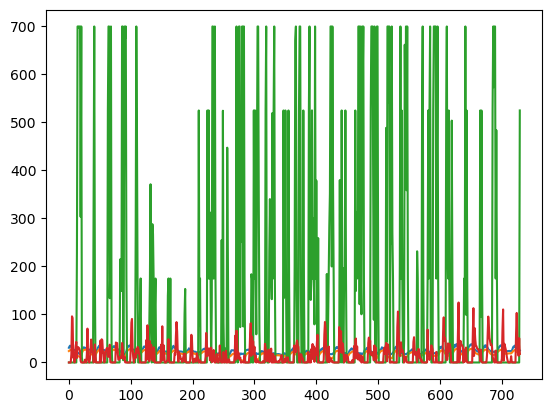

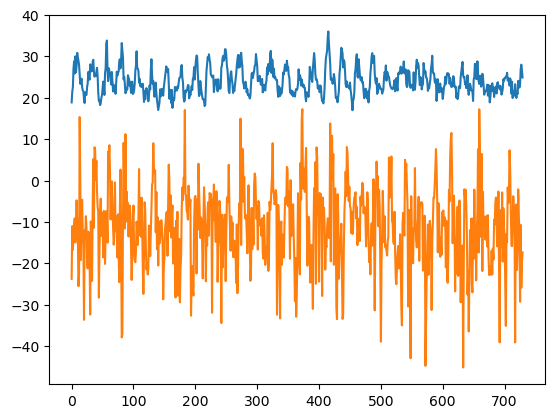

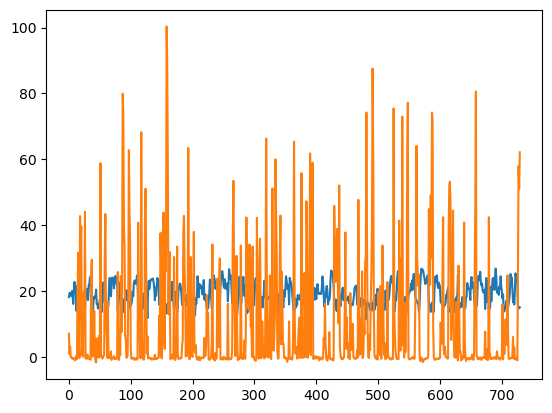

In [5]:
plt.plot(base_data_train[100])
plt.show()
plt.plot(vae_data_train_rescaled[100])
plt.show()
plt.plot(gan_data_train_rescaled[100])
plt.show()

In [12]:
'''def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear') #Dense(1)
    ])
    return model

def create_cnn(input_length):
    model = Sequential([
        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),
        Dropout(0.5),
        LSTM(32, return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(50, activation='relu'),
        Dense(730, activation='linear')  # Output layer for regression
    ])
    return model'''

"def create_cnn(input_shape):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(input_shape)),\n        MaxPooling1D(pool_size=2),\n        Flatten(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear') #Dense(1)\n    ])\n    return model\n\ndef create_cnn(input_length):\n    model = Sequential([\n        Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(input_length, 1)),\n        Dropout(0.5),\n        LSTM(32, return_sequences=True),\n        GlobalAveragePooling1D(),\n        Dense(50, activation='relu'),\n        Dense(730, activation='linear')  # Output layer for regression\n    ])\n    return model"

In [4]:
def create_cnn(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=24, activation='relu', input_shape=(input_shape)),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Conv1D(filters=64, kernel_size=24, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.25),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(730, activation='linear')
    ])
    return model

In [8]:
print(base_data_train[:,:,0].shape)

(108, 730)


<h3> Scaling data before evaluation </h3>

Scale base dataset and use the scaled vae dataset

In [9]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I', 'G.sky.T', 'G.E_el_I']}

air_var, sky_var, el_var, th_var = base_data_train[:,:,0], base_data_train[:,:,1], base_data_train[:,:,2], base_data_train[:,:,3]
air_var_test, sky_var_test, el_var_test, th_var_test = base_data_test[:,:,0], base_data_test[:,:,1], base_data_test[:,:,2], base_data_test[:,:,3]

scaled_data_train = np.stack((scalers['G.air.T'].fit_transform(air_var),
                             scalers['G.sky.T'].fit_transform(sky_var),
                             scalers['G.E_el_I'].fit_transform(el_var),
                             scalers['G.E_th_I'].fit_transform(th_var)), axis=-1)
scaled_data_test = np.stack((scalers['G.air.T'].fit_transform(air_var),
                             scalers['G.sky.T'].fit_transform(sky_var),
                             scalers['G.E_el_I'].fit_transform(el_var),
                             scalers['G.E_th_I'].fit_transform(th_var)), axis=-1)
print(scaled_data_train.shape, scaled_data_test.shape)

(108, 730, 4) (108, 730, 4)


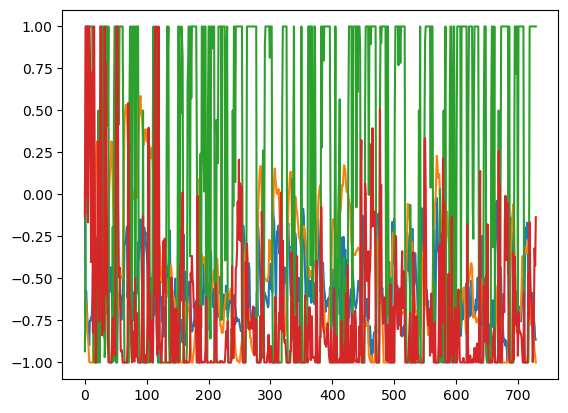

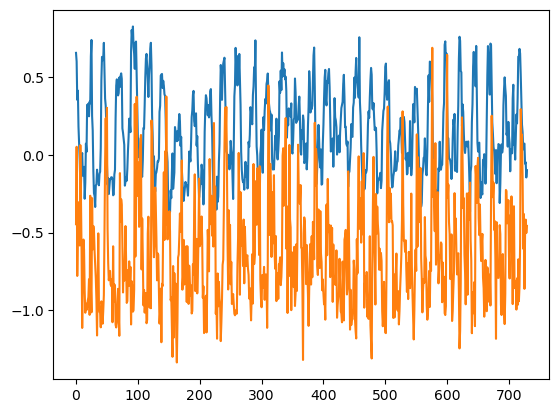

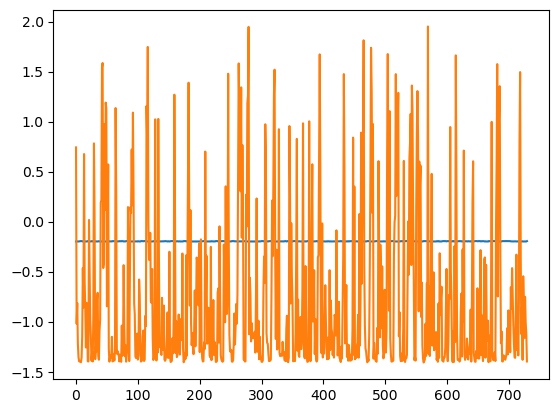

In [10]:
plt.plot(scaled_data_train[0])
plt.show()
plt.plot(vae_data_train[0])
plt.show()
plt.plot(gan_data_train[0])
plt.show()

In [5]:
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [6]:
def test_cnn(training_data, th_or_el):
    X_train = training_data[:,:,0].reshape(-1,730,1)
    y_train = training_data[:,:,1]

    if th_or_el == 0:
        X_test = scaled_data_test[:,:,0].reshape(-1, 730, 1)  
        y_test = scaled_data_test[:,:,3]
    else:
        X_test = scaled_data_test[:,:,1].reshape(-1, 730, 1)  
        y_test = scaled_data_test[:,:,2]

    X_train, X_train_val, y_train, y_train_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)
                                                                  
    model = create_cnn((X_train.shape[1], X_train.shape[2]))
    model.compile(optimizer=Adam(), loss='mse', metrics=['mse', 'mae'])

    early_stopping = EarlyStopping(monitor='mse', patience=10, verbose=1, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='mse', factor=0.5, patience=5, verbose=1)
    model.fit(X_train, y_train, epochs=100, batch_size=16, callbacks=[early_stopping, reduce_lr], verbose=0, validation_data=(X_train_val, y_train_val))

    loss, mse, mae = model.evaluate(X_test, y_test)
    r2 = r_squared(tf.convert_to_tensor(y_test, dtype=tf.float32), tf.convert_to_tensor(model.predict(X_test), dtype=tf.float32))
    
    return {'mse':mse, 'mae':mae, 'r2':r2.numpy()}


In [7]:
num_reps = 20

def test_cnn_wrapper(data, th_or_el=0):
    mse, mae, r2 = 0, 0, 0

    # Run each CNN training 10 times to ensure results are significant and not outliers
    for i in range(num_reps):
        print(f'RUN: {i}')
        results = test_cnn(np.random.permutation(data), th_or_el) # permuting the data for each run just to ensure full shuffling
        mse += results['mse']
        mae += results['mae']
        r2  += results['r2']

    return {'mse':mse/num_reps, 'mae':mae/num_reps, 'r2':r2/num_reps}
        

In [14]:
base_data_train, base_data_test = np.load('../../data/training_data/training_data_1month.npy', allow_pickle=True)

th_vae_data_train1 = np.load(f'../../data/vae_synthetic_data/th_v_air_b8l15_generated_samples.npy')
th_vae_data_train2 = np.load(f'../../data/vae_synthetic_data/th_v_air_b8l25_generated_samples.npy')
th_vae_data_train3 = np.load(f'../../data/vae_synthetic_data/th_v_air_b20l25_generated_samples.npy')
el_vae_data_train1 = np.load(f'../../data/vae_synthetic_data/el_v_sky_b32l5_generated_samples.npy')
el_vae_data_train2 = np.load(f'../../data/vae_synthetic_data/el_v_sky_b32l20_generated_samples.npy')
el_vae_data_train3 = np.load(f'../../data/vae_synthetic_data/el_v_sky_b32l3_generated_samples.npy')
el_vae_data_train4 = np.load(f'../../data/vae_synthetic_data/el_v_sky_b24l25_generated_samples.npy')

th_gan_data_train1 = np.load(f'../../data/gan_synthetic_data/th_v_air_b10e1000_generated_samples.npy')
th_gan_data_train2 = np.load(f'../../data/gan_synthetic_data/th_v_air_b10e100_generated_samples.npy')
th_gan_data_train3 = np.load(f'../../data/gan_synthetic_data/th_v_air_b32e1000_generated_samples.npy')
el_gan_data_train1 = np.load(f'../../data/gan_synthetic_data/el_v_sky_b32e1000_generated_samples.npy')
el_gan_data_train2 = np.load(f'../../data/gan_synthetic_data/el_v_sky_b32e500_generated_samples.npy')
el_gan_data_train3 = np.load(f'../../data/gan_synthetic_data/el_v_sky_b20e100_generated_samples.npy')
el_gan_data_train4 = np.load(f'../../data/gan_synthetic_data/el_v_sky_b10e100_generated_samples.npy')

th_base_data_train, th_base_data_test = base_data_train[:,:,[0,3]], base_data_test[:,:,[0,3]]
el_base_data_train, el_base_data_test = base_data_train[:,:,[1,2]], base_data_test[:,:,[1,2]]

print(th_base_data_train.shape, th_base_data_test.shape, el_base_data_train.shape, el_base_data_test.shape)
print(th_vae_data_train1.shape, th_vae_data_train2.shape, el_vae_data_train1.shape, el_vae_data_train2.shape, el_vae_data_train3.shape)
print(th_gan_data_train1.shape, th_gan_data_train2.shape, el_gan_data_train1.shape, el_gan_data_train2.shape)

(108, 730, 2) (12, 730, 2) (108, 730, 2) (12, 730, 2)
(1000, 730, 2) (1000, 730, 2) (1000, 730, 2) (1000, 730, 2) (1000, 730, 2)
(1000, 730, 2) (1000, 730, 2) (1000, 730, 2) (1000, 730, 2)


In [15]:
from sklearn.preprocessing import MinMaxScaler

scalers = {var_name: MinMaxScaler(feature_range=(-1,1)) for var_name in ['G.air.T', 'G.E_th_I', 'G.sky.T', 'G.E_el_I']}

air_var, sky_var, el_var, th_var = base_data_train[:,:,0], base_data_train[:,:,1], base_data_train[:,:,2], base_data_train[:,:,3]
air_var_test, sky_var_test, el_var_test, th_var_test = base_data_test[:,:,0], base_data_test[:,:,1], base_data_test[:,:,2], base_data_test[:,:,3]

scaled_data_train = np.stack((scalers['G.air.T'].fit_transform(air_var),
                             scalers['G.sky.T'].fit_transform(sky_var),
                             scalers['G.E_el_I'].fit_transform(el_var),
                             scalers['G.E_th_I'].fit_transform(th_var)), axis=-1)
scaled_data_test = np.stack((scalers['G.air.T'].fit_transform(air_var),
                             scalers['G.sky.T'].fit_transform(sky_var),
                             scalers['G.E_el_I'].fit_transform(el_var),
                             scalers['G.E_th_I'].fit_transform(th_var)), axis=-1)

th_scaled_data_train = scaled_data_train[:,:,[0,3]]
el_scaled_data_train = scaled_data_train[:,:,[1,2]]
print(th_scaled_data_train.shape, el_scaled_data_train.shape)

(108, 730, 2) (108, 730, 2)


Once this runs through once fully, reformat to be a function that is called over a list of datasets

In [ ]:
# Ground Truth
th_ground_truth = test_cnn_wrapper(th_scaled_data_train, 0)
pd.DataFrame(th_ground_truth, index=[0]).to_csv('../../data/evaluation_results/th_gt.csv')
el_ground_truth = test_cnn_wrapper(el_scaled_data_train, 1)
pd.DataFrame(el_ground_truth, index=[0]).to_csv('../../data/evaluation_results/el_gt.csv')


In [16]:
# Synthetic Only
th_vae_test = test_cnn_wrapper(th_vae_data_train1[0:216,:,:], 0)
pd.DataFrame(th_vae_test, index=[0]).to_csv('../../data/evaluation_results/th_vae1.csv')
th_vae_test = test_cnn_wrapper(th_vae_data_train2[0:216,:,:], 0)
pd.DataFrame(th_vae_test, index=[0]).to_csv('../../data/evaluation_results/th_vae2.csv')
th_vae_test = test_cnn_wrapper(th_vae_data_train3[0:216,:,:], 0)
pd.DataFrame(th_vae_test, index=[0]).to_csv('../../data/evaluation_results/th_vae3.csv')
el_vae_test = test_cnn_wrapper(el_vae_data_train1[0:216,:,:], 1)
pd.DataFrame(el_vae_test, index=[0]).to_csv('../../data/evaluation_results/el_vae1.csv')
el_vae_test = test_cnn_wrapper(el_vae_data_train2[0:216,:,:], 1)
pd.DataFrame(el_vae_test, index=[0]).to_csv('../../data/evaluation_results/el_vae2.csv')
el_vae_test = test_cnn_wrapper(el_vae_data_train3[0:216,:,:], 1)
pd.DataFrame(el_vae_test, index=[0]).to_csv('../../data/evaluation_results/el_vae3.csv')
el_vae_test = test_cnn_wrapper(el_vae_data_train4[0:216,:,:], 1)
pd.DataFrame(el_vae_test, index=[0]).to_csv('../../data/evaluation_results/el_vae4.csv')

th_gan_test = test_cnn_wrapper(th_gan_data_train1[0:216,:,:], 0)
pd.DataFrame(th_gan_test, index=[0]).to_csv('../../data/evaluation_results/th_gan1.csv')
th_gan_test = test_cnn_wrapper(th_gan_data_train2[0:216,:,:], 0)
pd.DataFrame(th_gan_test, index=[0]).to_csv('../../data/evaluation_results/th_gan2.csv')
th_gan_test = test_cnn_wrapper(th_gan_data_train3[0:216,:,:], 0)
pd.DataFrame(th_gan_test, index=[0]).to_csv('../../data/evaluation_results/th_gan3.csv')
el_gan_test = test_cnn_wrapper(el_gan_data_train1[0:216,:,:], 1)
pd.DataFrame(el_gan_test, index=[0]).to_csv('../../data/evaluation_results/el_gan1.csv')
el_gan_test = test_cnn_wrapper(el_gan_data_train2[0:216,:,:], 1)
pd.DataFrame(el_gan_test, index=[0]).to_csv('../../data/evaluation_results/el_gan2.csv')
el_gan_test = test_cnn_wrapper(el_gan_data_train3[0:216,:,:], 1)
pd.DataFrame(el_gan_test, index=[0]).to_csv('../../data/evaluation_results/el_gan3.csv')
el_gan_test = test_cnn_wrapper(el_gan_data_train4[0:216,:,:], 1)
pd.DataFrame(el_gan_test, index=[0]).to_csv('../../data/evaluation_results/el_gan4.csv')


RUN: 0


2024-04-02 17:37:14.644081: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa1c800c640 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-04-02 17:37:14.644114: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-04-02 17:37:14.891722: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1712075835.766620    4521 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-04-02 17:37:15.768944: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 17:37:15.769733: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-04-02 17:37:15.773002: E external/local_xla/xl

4/4 [==============================] - 0s 5ms/step
RUN: 1
4/4 [==============================] - 0s 5ms/step
RUN: 2

Epoch 58: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 6ms/step
RUN: 3

Epoch 97: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 4ms/step
RUN: 4

Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
4/4 [==============================] - 0s 4ms/step
RUN: 5
4/4 [==============================] - 0s 5ms/step
RUN: 6

Epoch 93: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 4ms/step
RUN: 7

Epoch 75: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 5ms/step
RUN: 8

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.00050000002

2024-04-02 17:43:06.820592: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


4/4 [==============================] - 0s 5ms/step
RUN: 16

Epoch 76: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 5ms/step
RUN: 17

Epoch 71: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 4ms/step
RUN: 18
4/4 [==============================] - 0s 5ms/step
RUN: 19
4/4 [==============================] - 0s 5ms/step
RUN: 0

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 6ms/step
RUN: 1
4/4 [==============================] - 0s 5ms/step
RUN: 2
4/4 [==============================] - 0s 4ms/step
RUN: 3

Epoch 92: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 4ms/step
RUN: 4
4/4 [==============================] - 0s 5ms/step
RUN: 5
4/4 [==============================] - 0s 4ms/step
RUN: 6

Epoch 88: ReduceLROnPlateau reducing learning


Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 73: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 85: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 80.

Epoch 90: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 90: early stopping
4/4 [==============================] - 0s 5ms/step
RUN: 2

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 74: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 86: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 97: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
4/4 [==============================] - 0s 5ms/step
RUN: 3

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 44.

Epoch 54: ReduceLROnPlateau reducing l

4/4 [==============================] - 0s 5ms/step
RUN: 0
4/4 [==============================] - 0s 5ms/step
RUN: 1
4/4 [==============================] - 0s 5ms/step
RUN: 2
4/4 [==============================] - 0s 5ms/step
RUN: 3
4/4 [==============================] - 0s 5ms/step
RUN: 4
4/4 [==============================] - 0s 5ms/step
RUN: 5
4/4 [==============================] - 0s 5ms/step
RUN: 6
4/4 [==============================] - 0s 4ms/step
RUN: 7
4/4 [==============================] - 0s 6ms/step
RUN: 8
4/4 [==============================] - 0s 5ms/step
RUN: 9
4/4 [==============================] - 0s 5ms/step
RUN: 10
4/4 [==============================] - 0s 4ms/step
RUN: 11
4/4 [==============================] - 0s 4ms/step
RUN: 12
4/4 [==============================] - 0s 4ms/step
RUN: 13
4/4 [==============================] - 0s 4ms/step
RUN: 14

Epoch 88: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 4ms/s

4/4 [==============================] - 0s 5ms/step
RUN: 18
4/4 [==============================] - 0s 5ms/step
RUN: 19

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 67: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
4/4 [==============================] - 0s 6ms/step
RUN: 0
4/4 [==============================] - 0s 5ms/step
RUN: 1
4/4 [==============================] - 0s 5ms/step
RUN: 2
4/4 [==============================] - 0s 5ms/step
RUN: 3
4/4 [==============================] - 0s 6ms/step
RUN: 4

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 5ms/step
RUN: 5
4/4 [==============================] - 0s 5ms/step
RUN: 6
4/4 [==============================] - 0s 4ms/step
RUN: 7
4/4 [==============================] - 0s 4ms/step
RUN: 8
4/4 [==============================] - 0s 5ms/step
RUN: 9
4/4 [==============================] - 0s 5ms/step
RUN: 10
4/4 [====


Epoch 72: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.

Epoch 80: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.

Epoch 85: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.

Epoch 90: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.

Epoch 95: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
Restoring model weights from the end of the best epoch: 88.
Epoch 98: early stopping
4/4 [==============================] - 0s 5ms/step
RUN: 5

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 50: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 55: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 60: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-

4/4 [==============================] - 0s 5ms/step
RUN: 2

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 41: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 54: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 59: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 65: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 74: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
Restoring model weights from the end of the best epoch: 69.

Epoch 79: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 79: early stopping
4/4 [==============================] - 0s 5ms/step
RUN: 3

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 22: ReduceL

Restoring model weights from the end of the best epoch: 65.

Epoch 75: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 75: early stopping
4/4 [==============================] - 0s 5ms/step
RUN: 12

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 52: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 59: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 68: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 74: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 79: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 88: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Restoring model weights from the end of the best epoch: 83.

Epoch 93: Redu

4/4 [==============================] - 0s 6ms/step
RUN: 6

Epoch 84: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 94: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
4/4 [==============================] - 0s 5ms/step
RUN: 7

Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 5ms/step
RUN: 8

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 5ms/step
RUN: 9
4/4 [==============================] - 0s 5ms/step
RUN: 10

Epoch 82: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 5ms/step
RUN: 11
4/4 [==============================] - 0s 5ms/step
RUN: 12

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 4ms/step
RUN: 13

Epoch 100: ReduceLROnPlateau reducing learning rate to 0.000500

4/4 [==============================] - 0s 6ms/step
RUN: 19

Epoch 96: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
4/4 [==============================] - 0s 5ms/step
RUN: 0

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 41: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 36.

Epoch 46: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 46: early stopping
4/4 [==============================] - 0s 6ms/step
RUN: 1

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 44: ReduceLROnPlateau reducing l


Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 41: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 36.

Epoch 46: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 46: early stopping
4/4 [==============================] - 0s 4ms/step
RUN: 14

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 36: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Restoring model weights from the end of the best epoch: 44.

Epoch 54: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 54: early stopping
4/4 [==============================] - 0s 4ms/step
RUN: 15

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 20: R

KeyboardInterrupt: 

In [ ]:
# Synthetic and Ground Truth
th_vae_blended_test = test_cnn_wrapper(np.concatenate((th_scaled_data_train, th_vae_data_train1[0:216,:,:]), axis=0), 0)
pd.DataFrame(th_vae_blended_test, index=[0]).to_csv('../../data/evaluation_results/th_blended_vae1.csv')
th_vae_blended_test = test_cnn_wrapper(np.concatenate((th_scaled_data_train, th_vae_data_train2[0:216,:,:]), axis=0), 0)
pd.DataFrame(th_vae_blended_test, index=[0]).to_csv('../../data/evaluation_results/th_blended_vae2.csv')
th_vae_blended_test = test_cnn_wrapper(np.concatenate((th_scaled_data_train, th_vae_data_train3[0:216,:,:]), axis=0), 0)
pd.DataFrame(th_vae_blended_test, index=[0]).to_csv('../../data/evaluation_results/th_blended_vae3.csv')
el_vae_blended_test = test_cnn_wrapper(np.concatenate((el_scaled_data_train, el_vae_data_train1[0:216,:,:]), axis=0), 1)
pd.DataFrame(el_vae_blended_test, index=[0]).to_csv('../../data/evaluation_results/el_blended_vae1.csv')
el_vae_blended_test = test_cnn_wrapper(np.concatenate((el_scaled_data_train, el_vae_data_train2[0:216,:,:]), axis=0), 1)
pd.DataFrame(el_vae_blended_test, index=[0]).to_csv('../../data/evaluation_results/el_blended_vae2.csv')
el_vae_blended_test = test_cnn_wrapper(np.concatenate((el_scaled_data_train, el_vae_data_train3[0:216,:,:]), axis=0), 1)
pd.DataFrame(el_vae_blended_test, index=[0]).to_csv('../../data/evaluation_results/el_blended_vae3.csv')
el_vae_blended_test = test_cnn_wrapper(np.concatenate((el_scaled_data_train, el_vae_data_train4[0:216,:,:]), axis=0), 1)
pd.DataFrame(el_vae_blended_test, index=[0]).to_csv('../../data/evaluation_results/el_blended_vae4.csv')

th_gan_blended_test = test_cnn_wrapper(np.concatenate((th_scaled_data_train, th_gan_data_train1[0:216,:,:]), axis=0), 0)
pd.DataFrame(th_gan_blended_test, index=[0]).to_csv('../../data/evaluation_results/th_blended_gan1.csv')
th_gan_blended_test = test_cnn_wrapper(np.concatenate((th_scaled_data_train, th_gan_data_train2[0:216,:,:]), axis=0), 0)
pd.DataFrame(th_gan_blended_test, index=[0]).to_csv('../../data/evaluation_results/th_blended_gan2.csv')
th_gan_blended_test = test_cnn_wrapper(np.concatenate((th_scaled_data_train, th_gan_data_train3[0:216,:,:]), axis=0), 0)
pd.DataFrame(th_gan_blended_test, index=[0]).to_csv('../../data/evaluation_results/th_blended_gan3.csv')
el_gan_blended_test = test_cnn_wrapper(np.concatenate((el_scaled_data_train, el_gan_data_train1[0:216,:,:]), axis=0), 1)
pd.DataFrame(el_gan_blended_test, index=[0]).to_csv('../../data/evaluation_results/el_blended_gan1.csv')
el_gan_blended_test = test_cnn_wrapper(np.concatenate((el_scaled_data_train, el_gan_data_train2[0:216,:,:]), axis=0), 1)
pd.DataFrame(el_gan_blended_test, index=[0]).to_csv('../../data/evaluation_results/el_blended_gan2.csv')
el_gan_blended_test = test_cnn_wrapper(np.concatenate((el_scaled_data_train, el_gan_data_train3[0:216,:,:]), axis=0), 1)
pd.DataFrame(el_gan_blended_test, index=[0]).to_csv('../../data/evaluation_results/el_blended_gan3.csv')
el_gan_blended_test = test_cnn_wrapper(np.concatenate((el_scaled_data_train, el_gan_data_train4[0:216,:,:]), axis=0), 1)
pd.DataFrame(el_gan_blended_test, index=[0]).to_csv('../../data/evaluation_results/el_blended_gan4.csv')


In [34]:
import glob

results = pd.DataFrame(columns=['mse', 'mae', 'r2'])

for file in glob.glob(f'../../data/evaluation_results/*.csv'):
    file_name = file.split('\\')[-1]
    df = pd.read_csv(file, index_col=0)
    df.index = [file_name[:-4]]
    results = pd.concat([results, df])

print(results)

                      mse       mae        r2
el_blended_gan1  0.401106  0.506184  0.425266
el_blended_gan2  0.393878  0.501171  0.435622
el_blended_gan3  0.349382  0.453823  0.499381
el_blended_gan4  0.328912  0.445018  0.528711
el_blended_vae1  0.313998  0.431539  0.550081
el_blended_vae2  0.394281  0.492115  0.435046
el_blended_vae3  0.274922  0.396521  0.606072
el_blended_vae4  0.324642  0.440414  0.534830
el_gan1          0.708426  0.761519 -0.015085
el_gan2          0.618297  0.708743  0.114059
el_gan3          1.824610  1.020559 -1.614434
el_gan4          0.694150  0.748694  0.005372
el_gt            0.295212  0.418862  0.576999
el_vae1          0.514752  0.580873  0.262425
el_vae2          0.614060  0.633380  0.120130
el_vae3          0.472139  0.532791  0.323485
el_vae4          0.575096  0.635256  0.175960
th_blended_gan1  0.114379  0.246571  0.358061
th_blended_gan2  0.093580  0.222279  0.474792
th_blended_gan3  0.115615  0.248933  0.351124
th_blended_vae1  0.085200  0.21420

In [37]:
th_order = ['th_gt', 'th_vae1', 'th_vae2', 'th_vae3', 'th_gan1', 'th_gan2', 'th_gan3', 
            'th_blended_vae1', 'th_blended_vae2', 'th_blended_vae3', 'th_blended_gan1', 'th_blended_gan2', 'th_blended_gan3']
el_order = ['el_gt', 'el_vae1', 'el_vae2', 'el_vae3', 'el_vae4', 'el_gan1', 'el_gan2', 'el_gan3', 'el_gan4',
            'el_blended_vae1', 'el_blended_vae2', 'el_blended_vae3', 'el_blended_gan1', 'el_blended_gan2', 'el_blended_gan3']

print(results.loc[th_order])
print(results.loc[el_order])

                      mse       mae        r2
th_gt            0.100243  0.236438  0.437395
th_vae1          0.109703  0.243108  0.384302
th_vae2          0.123112  0.255271  0.309048
th_vae3          0.163767  0.295799  0.080878
th_gan1          0.212745  0.387019 -0.194006
th_gan2          0.256495  0.450833 -0.439550
th_gan3          0.903065  0.895853 -4.068356
th_blended_vae1  0.085200  0.214202  0.521825
th_blended_vae2  0.085804  0.211536  0.518434
th_blended_vae3  0.092993  0.221092  0.478086
th_blended_gan1  0.114379  0.246571  0.358061
th_blended_gan2  0.093580  0.222279  0.474792
th_blended_gan3  0.115615  0.248933  0.351124
                      mse       mae        r2
el_gt            0.295212  0.418862  0.576999
el_vae1          0.514752  0.580873  0.262425
el_vae2          0.614060  0.633380  0.120130
el_vae3          0.472139  0.532791  0.323485
el_vae4          0.575096  0.635256  0.175960
el_gan1          0.708426  0.761519 -0.015085
el_gan2          0.618297  0.70874

In [43]:
print((results.loc['th_gt', 'mse'] - results.loc['th_vae1', 'mse']) / results.loc['th_gt', 'mse'])
print((results.loc['th_gt', 'mse'] - results.loc['th_gan1', 'mse']) / results.loc['th_gt', 'mse'])
print((results.loc['th_gt', 'mse'] - results.loc['th_blended_vae1', 'mse']) / results.loc['th_gt', 'mse'])
print((results.loc['th_gt', 'mse'] - results.loc['th_blended_gan2', 'mse']) / results.loc['th_gt', 'mse'])


-0.094370285751687
-1.1222821636043048
0.15006928330613825
0.06647013266049095


In [44]:
print((results.loc['el_gt', 'mse'] - results.loc['el_vae3', 'mse']) / results.loc['el_gt', 'mse'])
print((results.loc['el_gt', 'mse'] - results.loc['el_gan2', 'mse']) / results.loc['el_gt', 'mse'])
print((results.loc['el_gt', 'mse'] - results.loc['el_blended_vae3', 'mse']) / results.loc['el_gt', 'mse'])
print((results.loc['el_gt', 'mse'] - results.loc['el_blended_gan3', 'mse']) / results.loc['el_gt', 'mse'])

-0.5993226356533091
-1.0944205360841908
0.06872883712785727
-0.18349527418855696
